## Import Libraries & Set Up

In [ ]:
# import library
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

SEED = 42
warnings.filterwarnings('ignore')
tf.random.set_seed(SEED)
np.random.seed(SEED)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,4)

## Load Dataset

In [ ]:
# read dataset
path = '/content/Data Historis Jakarta Stock Exchange Composite.csv'

df = pd.read_csv(path)
df.head()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,29/08/2025,"7.830,49","7.899,89","7.913,86","7.765,60","48,13B","-1,53%"
1,28/08/2025,"7.952,09","7.951,87","8.022,76","7.941,94","39,93B","0,20%"
2,27/08/2025,"7.936,18","7.923,00","7.945,44","7.894,76","35,76B","0,38%"
3,26/08/2025,"7.905,76","7.971,79","7.978,07","7.881,21","50,49B","-0,27%"
4,25/08/2025,"7.926,91","7.921,02","7.951,98","7.915,05","37,63B","0,87%"


In [ ]:
# convert Tanggal to datetime
df.columns = [c.strip() for c in df.columns]
df["Tanggal"] = pd.to_datetime(df["Tanggal"], dayfirst=True, errors="coerce")
df = df.sort_values("Tanggal").dropna(subset=["Tanggal"]).set_index("Tanggal")

## Pre-processing

In [ ]:
# Load & cleaning
def parse_vol(s):
    if pd.isna(s):
      return np.nan
    s = str(s).replace('.', '').replace(',', '.')  # id locale
    mult = 1.0
    if s.endswith(('K','k')):
      mult, s = 1e3, s[:-1]
    if s.endswith(('M','m')):
      mult, s = 1e6, s[:-1]
    if s.endswith(('B','b')):
      mult, s = 1e9, s[:-1]
    try:
      return float(s) * mult
    except:
      return np.nan

def to_float(x):
    return pd.to_numeric(str(x).replace('.', '').replace(',', '.'), errors='coerce')

In [ ]:
# konversi kolom numerik
for col in ["Terakhir","Pembukaan","Tertinggi","Terendah"]:
    df[col] = df[col].apply(to_float)

df["Vol."] = df["Vol."].apply(parse_vol)

In [ ]:
# Forward-fill harga yang kosong (mis. hari libur)
for col in ["Terakhir","Pembukaan","Tertinggi","Terendah"]:
    df[col] = df[col].ffill()

In [ ]:
price = df["Terakhir"] # target fitur
ret = np.log(price).diff()                 # log-return

# OHLC based features
df["log_return"] = ret
df["hl_range"] = (df["Tertinggi"] - df["Terendah"]) / df["Pembukaan"].replace(0, np.nan)
df["vol_log"] = np.log1p(df["Vol."])

# lags & rolling volatility
df["rolling_vol_10"] = df["log_return"].rolling(10).std()
df["rolling_vol_20"] = df["log_return"].rolling(20).std()

## EDA

In [ ]:
print("Descriptive Stats (harga)")
price.describe()

Descriptive Stats (harga)


,Terakhir
count,1365.000000
mean,6571.538308
std,770.784258
min,3937.630000
25%,6126.920000
50%,6811.310000
75%,7096.440000
max,7952.090000


In [ ]:
print("Descriptive Stats (log-return")
print(df["log_return"].describe())
print("Skewness:", skew(df["log_return"].dropna()))
print("Kurtosis:", kurtosis(df["log_return"].dropna(), fisher=True))

Descriptive Stats (log-return
count    1364.000000
mean        0.000161
std         0.010789
min        -0.082319
25%        -0.004912
50%         0.000528
75%         0.005641
max         0.097042
Name: log_return, dtype: float64
Skewness: -0.3536970258208429
Kurtosis: 10.971999985910285


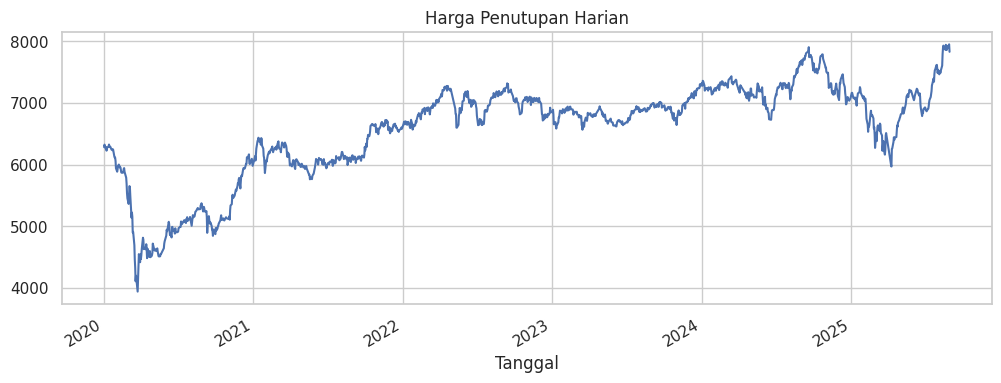

In [ ]:
# Plot harga
price.plot(title="Harga Penutupan Harian")
plt.show()

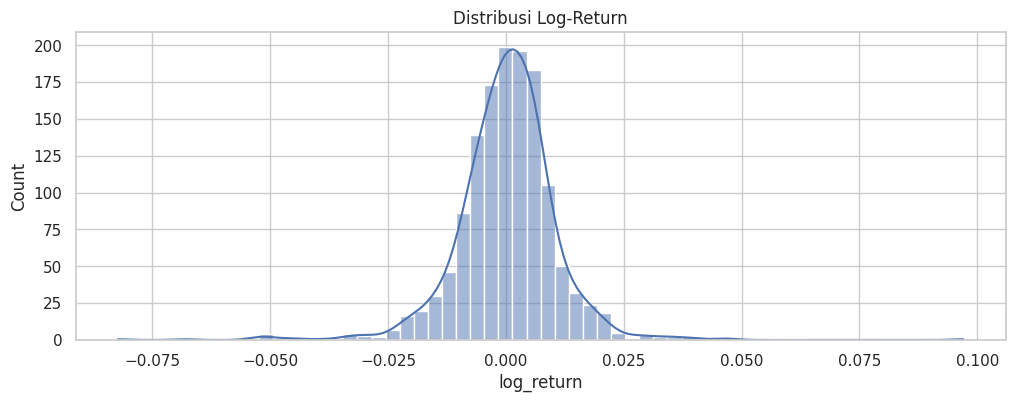

In [ ]:
# Distribusi return
sns.histplot(df["log_return"].dropna(), bins=60, kde=True)
plt.title("Distribusi Log-Return")
plt.show()

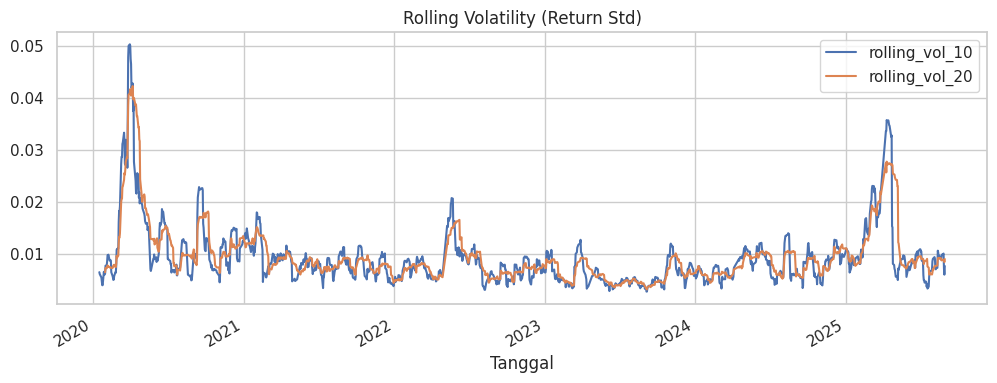

In [ ]:
# Volatilitas rolling
df[["rolling_vol_10","rolling_vol_20"]].plot(title="Rolling Volatility (Return Std)")
plt.show()

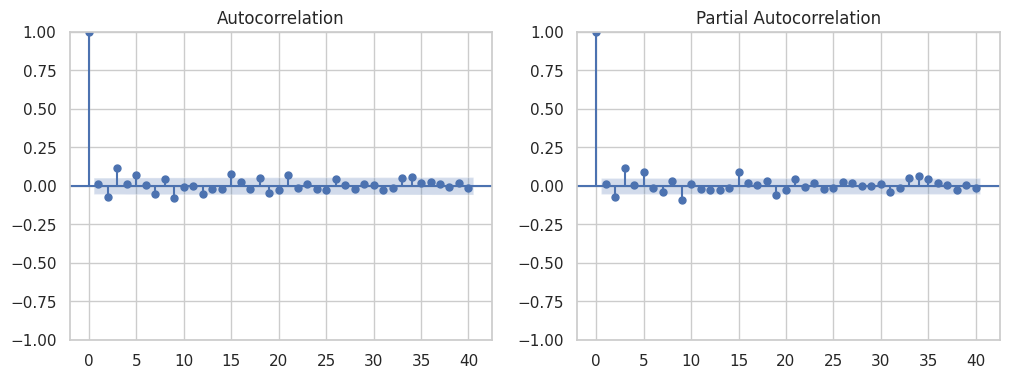

In [ ]:
# ACF & PACF return
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(df["log_return"].dropna(), lags=40, ax=ax[0])
plot_pacf(df["log_return"].dropna(), lags=40, ax=ax[1], method="ywm")
plt.show()

In [ ]:
# Stationarity tests
def adf_test(s, name="series"):
    s = s.dropna()
    res = adfuller(s, autolag='AIC')
    print(f"[ADF] {name}: p-value={res[1]:.5f}")

def kpss_test(s, name="series"):
    s = s.dropna()
    try:
        stat, pval, _, _ = kpss(s, regression='c', nlags='auto')
        print(f"[KPSS] {name}: p-value={pval:.5f}")
    except Exception as e:
        print(f"[KPSS] {name} gagal: {e}")

In [ ]:
adf_test(price, "Harga (level)")
kpss_test(price, "Harga (level)")
adf_test(df["log_return"], "Log-Return")
kpss_test(df["log_return"], "Log-Return")

[ADF] Harga (level): p-value=0.66951
[KPSS] Harga (level): p-value=0.01000
[ADF] Log-Return: p-value=0.00000
[KPSS] Log-Return: p-value=0.10000


## SARIMAX dengan exogenous OHLCV

In [ ]:
# data splitting
y = df["log_return"].dropna()
X = df[["hl_range","vol_log"]].shift(1).dropna()
y, X = y.loc[X.index], X

In [ ]:
# shape X, y
print(X.shape, y.shape)

(1361, 2) (1361,)


In [ ]:
# train test split (80:20)
split = int(0.8 * len(y))
y_tr, y_te = y.iloc[:split], y.iloc[split:]
X_tr, X_te = X.iloc[:split], X.iloc[split:]

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1088, 2), (273, 2), (1088,), (273,))

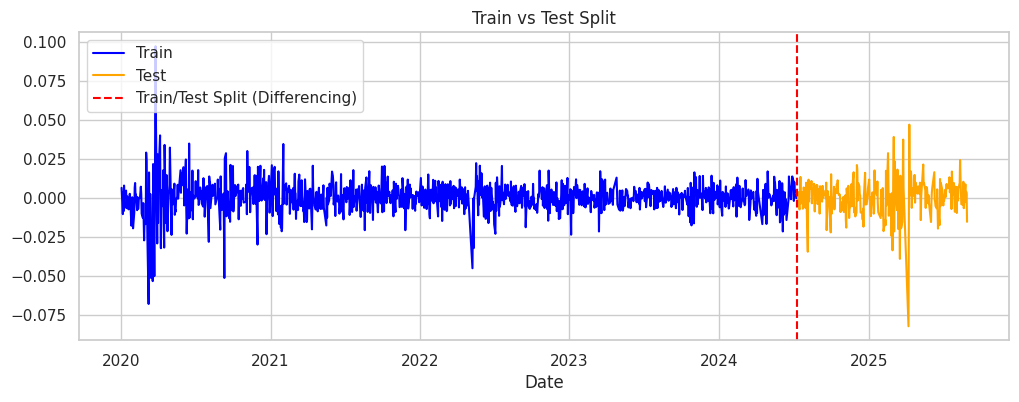

In [ ]:
# Plot data train
plt.plot(y_tr.index, y_tr, label='Train', color='blue')
# Plot data test
plt.plot(y_te.index, y_te, label='Test', color='orange')

plt.axvline(x=y_te.index[0], color='red', linestyle='--', label='Train/Test Split (Differencing)')

# Tambahkan label
plt.xlabel('Date')
plt.title('Train vs Test Split')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# inisialisasi sarimax
sarima = SARIMAX(y_tr, exog=X_tr, order=(0,0,1), enforce_stationarity=False, enforce_invertibility=False)

# fitting
res = sarima.fit(disp=False)

In [ ]:
# sarima summary
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 1088
Model:               SARIMAX(0, 0, 1)   Log Likelihood                3409.738
Date:                Sat, 30 Aug 2025   AIC                          -6811.475
Time:                        06:28:25   BIC                          -6791.514
Sample:                             0   HQIC                         -6803.919
                               - 1088                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hl_range       0.0053      0.015      0.348      0.728      -0.025       0.035
vol_log     4.315e-06   2.24e-05      0.192      0.847   -3.96e-05    4.82e-05
ma.L1          0.0135      0.015      0.870      0.3

In [ ]:
# pred & eval
y_pred_arima = res.get_forecast(steps=len(y_te), exog=X_te).predicted_mean
resid = y_tr - res.fittedvalues

print("=== Evaluasi ARIMA (return) ===")
print("MAE:", mean_absolute_error(y_te, y_pred_arima))
print("RMSE:", mean_squared_error(y_te, y_pred_arima))

=== Evaluasi ARIMA (return) ===
MAE: 0.008375024449546329
RMSE: 0.00014240164109597406


## Build LSTM untuk Residual

In [ ]:
# feature scaling
scaler = MinMaxScaler()
resid_scaled = scaler.fit_transform(resid.values.reshape(-1,1))

def make_seq(data, n_lags=10):
    Xs, ys = [], []
    for i in range(n_lags, len(data)):
        Xs.append(data[i-n_lags:i, 0])
        ys.append(data[i, 0])
    return np.array(Xs), np.array(ys)

In [ ]:
# define lags
n_lags = 10
X_seq, y_seq = make_seq(resid_scaled, n_lags=n_lags)

# data splitting for LSTM
cut = int(0.8 * len(X_seq))
X_lstm_tr, X_lstm_te = X_seq[:cut], X_seq[cut:]
y_lstm_tr, y_lstm_te = y_seq[:cut], y_seq[cut:]

X_lstm_tr = X_lstm_tr.reshape((X_lstm_tr.shape[0], n_lags, 1))
X_lstm_te = X_lstm_te.reshape((X_lstm_te.shape[0], n_lags, 1))

print(X_lstm_tr.shape, X_lstm_te.shape, y_lstm_tr.shape, y_lstm_te.shape)

(862, 10, 1) (216, 10, 1) (862,) (216,)


In [ ]:
# LSTM model
lstm = Sequential([
    LSTM(128, activation="tanh", input_shape=(n_lags,1)),
    Dense(1)
])

# compile
lstm.compile(optimizer="adam", loss="mse")

In [ ]:
# callbacks
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# fitting
lstm.fit(X_lstm_tr, y_lstm_tr, epochs=100, batch_size=32, validation_data=(X_lstm_te, y_lstm_te), callbacks=[es], verbose=0)

In [ ]:
# predict lstm
res_pred_scaled = lstm.predict(X_lstm_te, verbose=0)
res_pred = scaler.inverse_transform(res_pred_scaled).flatten()

## Hybrid Forecast & Evaluasi

In [ ]:
# samakan panjang prediksi
y_pred_arima_test = y_pred_arima[-len(res_pred):]
y_pred_hybrid = y_pred_arima_test + res_pred

print("Evaluasi Hybrid (return)")
print("MAE:", mean_absolute_error(y_te[-len(y_pred_hybrid):], y_pred_hybrid))
print("RMSE:", mean_squared_error(y_te[-len(y_pred_hybrid):], y_pred_hybrid))

Evaluasi Hybrid (return)
MAE: 0.009108897367149283
RMSE: 0.0001652813900527843


In [ ]:
h = 10  # jumlah hari ke depan
use_business_days = True  # True = hanya hari kerja

# Forecast return dari SARIMAX
if X is not None and len(X) > 0:
    last_row = X.iloc[[-1]].copy()
    X_future = pd.concat([last_row] * h, ignore_index=True)
    sarimax_fc = res.get_forecast(steps=h, exog=X_future).predicted_mean
else:
    sarimax_fc = res.get_forecast(steps=h).predicted_mean

# Forecast residual dengan LSTM (recursive)
res_full = (y - res.get_prediction(exog=X).predicted_mean).dropna()

# scaling
sc_res = MinMaxScaler().fit(res_full.values.reshape(-1,1))

buf = sc_res.transform(res_full.values.reshape(-1,1)).flatten().tolist()
lstm_res_fc = []
for _ in range(h):
    x_in = np.array(buf[-n_lags:]).reshape(1, n_lags, 1)
    yhat_scaled = lstm.predict(x_in, verbose=0).flatten()[0]
    lstm_res_fc.append(yhat_scaled)
    buf.append(yhat_scaled)
lstm_res_fc = sc_res.inverse_transform(np.array(lstm_res_fc).reshape(-1,1)).flatten()

# Hybrid return
ret_fc = sarimax_fc.values + lstm_res_fc

# Rekonstruksi ke level harga
p0 = price.iloc[-1]
if use_business_days:
    future_idx = pd.bdate_range(price.index[-1] + pd.Timedelta(days=1), periods=h)
else:
    future_idx = pd.date_range(price.index[-1] + pd.Timedelta(days=1), periods=h, freq="D")

price_fc = p0 * np.exp(np.cumsum(ret_fc))
price_fc = pd.Series(price_fc, index=future_idx)

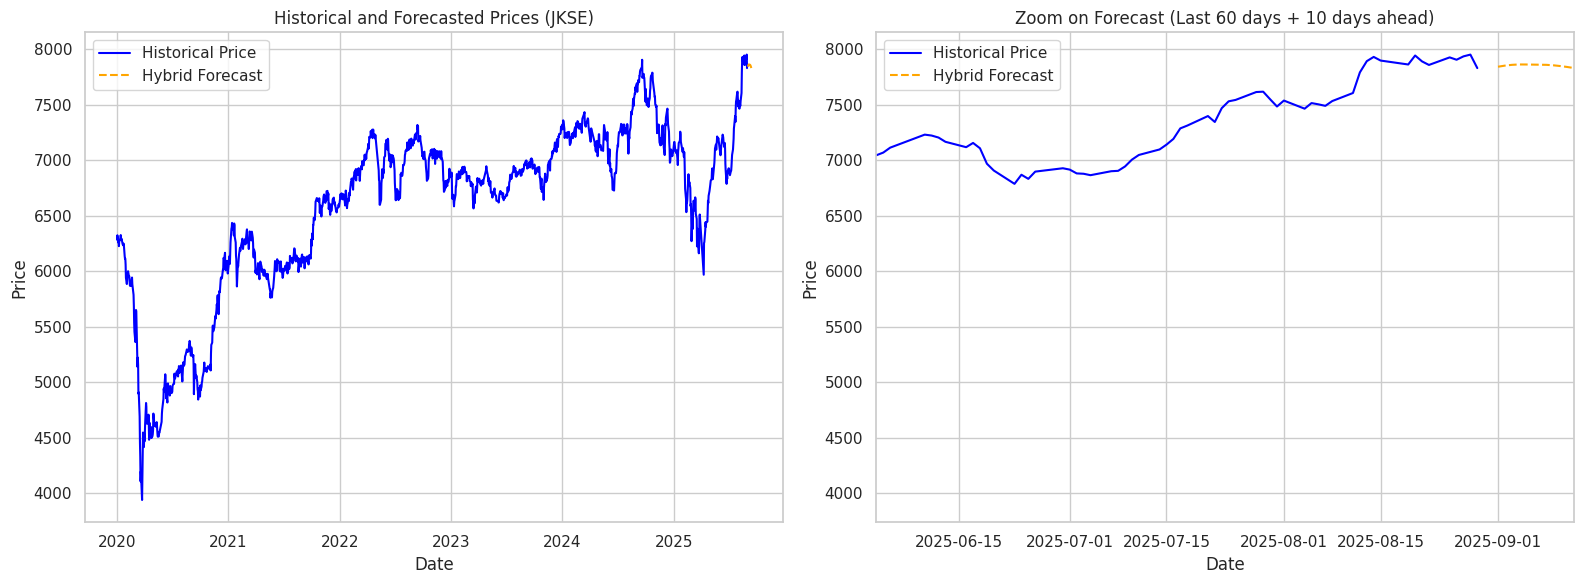

In [ ]:
# Plot historical + forecast (full vs zoom)
fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Kiri: full timeline
ax[0].plot(price.index, price, label='Historical Price', color='blue')
ax[0].plot(price_fc.index, price_fc, label='Hybrid Forecast', color='orange', linestyle='--')
ax[0].set_title('Historical and Forecasted Prices (JKSE)')
ax[0].set_xlabel('Date'); ax[0].set_ylabel('Price')
ax[0].legend(); ax[0].grid(True)

# Kanan: zoom ke forecast
ax[1].plot(price.index, price, label='Historical Price', color='blue')
ax[1].plot(price_fc.index, price_fc, label='Hybrid Forecast', color='orange', linestyle='--')
# zoom ke sekitar forecast (misal 3 bulan terakhir + 10 hari forecast)
ax[1].set_xlim(price.index[-60], price_fc.index[-1])
ax[1].set_title('Zoom on Forecast (Last 60 days + 10 days ahead)')
ax[1].set_xlabel('Date'); ax[1].set_ylabel('Price')
ax[1].legend(); ax[1].grid(True)

plt.tight_layout()
plt.show()